In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_diffusion, evidence_meta_diffusion
from src.python.helpers import load_empirical_rt_data, join_and_fill_missings, mask_inputs
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.facecolor'] = 'w'

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 
from bayesflow.losses import log_loss

# Application to empirical data

## Load in data

In [2]:
# Load data from folders

parent_folder = os.path.dirname(os.path.dirname(os.getcwd()))
color_folder = os.path.join(parent_folder, 'data\\Levy_flight_application\\data_rts\\color')
lexical_folder = os.path.join(parent_folder, 'data\\Levy_flight_application\\data_rts\\lexical')

color_data = load_empirical_rt_data(color_folder)
lexical_data = load_empirical_rt_data(lexical_folder)

# Join experimental data and fill missing values
empirical_data = join_and_fill_missings(color_data, lexical_data, n_trials=900, missing_rts_equal_mean=True)

## Load in trained network

In [3]:
summary_net = HierarchicalInvariantNetwork(summary_meta_diffusion)
evidence_net = EvidentialNetwork(evidence_meta_diffusion)
amortizer = MultiModelAmortizer(evidence_net, summary_net)

# Checkpoint path for loading pretrained network and saving the final network
trial_folder = 'trial_4'
checkpoint_path = os.path.join(os.getcwd(), 'training_checkpoints', trial_folder)

trainer = ModelComparisonTrainer(
    network=amortizer, 
    loss=partial(log_loss, kl_weight=0),
    optimizer=partial(Adam),
    checkpoint_path=checkpoint_path,
    skip_checks=True
    )

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from c:\Users\lasse\Dropbox\Uni Mannheim\M.Sc\4. Semester\Masterarbeit\Coding\notebooks\03_levy_flight_application\training_checkpoints\trial_4\ckpt-64


## Predict

In [4]:
labels = ['Basic Diffusion Model',
          'Basic Lévy Flight Model',
           'Full Diffusion Model',
           'Full Lévy Flight Model',]
           
preds = evidence_net.predict(summary_net(empirical_data))
preds

{'m_probs': array([[0.12481197, 0.12581766, 0.53787893, 0.21149142]], dtype=float32),
 'm_var': array([[0.01188062, 0.01196259, 0.02703471, 0.01813763]], dtype=float32),
 'uncertainty': array([[0.48814434]], dtype=float32)}

In [5]:
pd.DataFrame(preds['m_probs'], index=['Posterior model probability'], columns=labels)

,Basic Diffusion Model,Basic Lévy Flight Model,Full Diffusion Model,Full Lévy Flight Model
Posterior model probability,0.124812,0.125818,0.537879,0.211491


In [6]:
bfs = []

for model in range(4):
    for model_prob in preds['m_probs']:
        model_bfs = model_prob/preds['m_probs'][0][model]
        bfs.append(model_bfs.round(2))

pd.DataFrame(bfs, index=labels, columns=labels)

,Basic Diffusion Model,Basic Lévy Flight Model,Full Diffusion Model,Full Lévy Flight Model
Basic Diffusion Model,1.00,1.01,4.31,1.69
Basic Lévy Flight Model,0.99,1.00,4.28,1.68
Full Diffusion Model,0.23,0.23,1.00,0.39
Full Lévy Flight Model,0.59,0.59,2.54,1.00


In [7]:
evidences = evidence_net(summary_net(empirical_data))
dirichlet = evidence_net.sample(summary_net(empirical_data),10000)
dirichlet = np.squeeze(dirichlet)

Text(0, 0.5, 'Approximated posterior model probability')

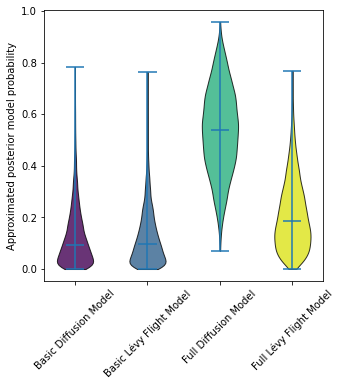

In [20]:
fig, ax = plt.subplots(figsize=(5,5))

# TODO: 
# Change line colors. to black?
# Test palette for line plots -> is yellow visible?

violin_plot = ax.violinplot(dirichlet, showmedians=True)
colors = ('#440154FF', '#33638DFF', '#29AF7FFF', '#DCE319FF')
for c, vp in zip(colors, violin_plot['bodies']):
    vp.set_facecolor(c)
    vp.set_edgecolor('black')
    vp.set_alpha(0.8)

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel('Model posterior')
#fig.savefig('Diffusion_violin_plot.png', dpi=300, bbox_inches='tight')

# Robustness checks

## Additional noise

In [14]:
def mean_predictions_noisy_data(empirical_data, evidence_net, summary_net, missings_mean, n_runs):

    noise_proportion = []
    probs = []
    vars = []

    for r in range(n_runs):
        noisy_data = mask_inputs(empirical_data, missings_mean=missings_mean, missings_sd=13.5, missing_rts_equal_mean=True, insert_additional_missings=True)
        noise_proportion_run = (noisy_data == -1).sum()/(40*900)
        noise_proportion.append(noise_proportion_run)
        preds = evidence_net.predict(summary_net(noisy_data))
        probs.append(preds['m_probs'])
        vars.append(preds['m_var'])
    
    mean_noise_proportion = np.mean(noise_proportion)
    mean_probs = np.mean(probs, axis=0)
    mean_vars = np.mean(vars, axis=0)
    
    return mean_noise_proportion, mean_probs, mean_vars


In [45]:
mean_noise_proportion, mean_probs, mean_vars = mean_predictions_noisy_data(empirical_data, evidence_net, summary_net, missings_mean=180, n_runs=100)

In [46]:
print(f'mean_noise_proportion: {mean_noise_proportion}')
print(f'mean_probs: {mean_probs}')
print(f'mean_vars: {mean_vars}')

mean_noise_proportion: 0.20770083333333336
mean_probs: [[0.134081   0.13316798 0.54897577 0.18377504]]
mean_vars: [[0.01405235 0.0139815  0.02645076 0.0176365 ]]


## Resampled trials within participants

In [190]:
# TODO: Refactor into bootstrapping function (together with bridge sampling comparison bootstrapped_metrics function?)

In [157]:
# Bootstrap trials

n_bootstrap = 100
bootstrapped_probs = []
n_trials = empirical_data.shape[2]

for b in range(n_bootstrap):
    b_idx = np.random.choice(np.arange(n_trials), size=n_trials, replace=True)
    bootstrapped_data = empirical_data[:,:,b_idx,:]
    probs = evidence_net.predict(summary_net(bootstrapped_data))['m_probs']
    bootstrapped_probs.append(probs)

bootstrapped_probs = np.asarray(bootstrapped_probs)[:,0,:]

In [161]:
# Bootstrap participants

n_bootstrap = 100
bootstrapped_probs = []
n_participants = empirical_data.shape[1]

for b in range(n_bootstrap):
    b_idx = np.random.choice(np.arange(n_participants), size=n_participants, replace=True)
    bootstrapped_data = empirical_data[:,b_idx,:,:]
    probs = evidence_net.predict(summary_net(bootstrapped_data))['m_probs']
    bootstrapped_probs.append(probs)

bootstrapped_probs = np.asarray(bootstrapped_probs)[:,0,:]

In [189]:
# Drop participants (leave one out)

bootstrapped_probs = []
n_participants = empirical_data.shape[1]

for b in range(n_participants):
    cropped_data = np.delete(empirical_data, b, axis=1)
    probs = evidence_net.predict(summary_net(cropped_data))['m_probs']
    bootstrapped_probs.append(probs)

bootstrapped_probs = np.asarray(bootstrapped_probs)[:,0,:]

In [183]:
modes = [np.argmax(bootstrapped_probs[sample]) for sample in range(n_participants)]
unique, counts = np.unique(modes, return_counts=True)
dict(zip(unique, counts))

{2: 40}

Text(0, 0.5, 'Approximated posterior model probability')

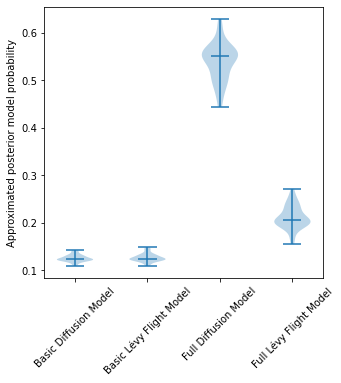

In [187]:
fig, ax = plt.subplots(figsize=(5,5))

ax.violinplot(bootstrapped_probs, showmedians=True)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel('Approximated posterior model probability')